In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Introduction

Data sources from: [the future 50 from 2020](https://www.restaurantbusinessonline.com/future-50-2020):

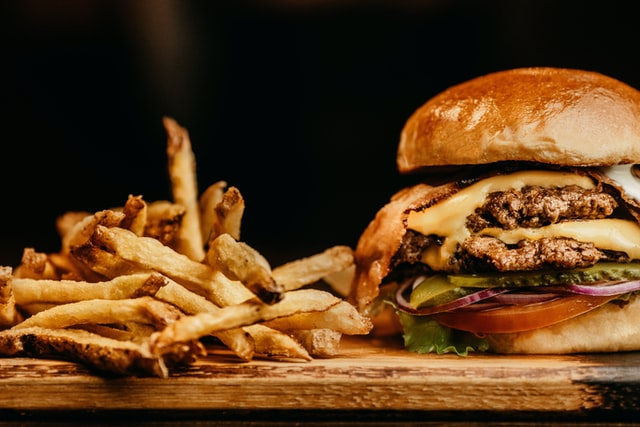

In [ ]:
#Libraries
#Plotly <3
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio

pio.templates.default = "seaborn"

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

In [ ]:
#Reading the data

top250_data = pd.read_csv('/kaggle/input/restaurant-business-rankings-2020/Top250.csv')
future50_data = pd.read_csv('/kaggle/input/restaurant-business-rankings-2020/Future50.csv')
independence100_data = pd.read_csv('/kaggle/input/restaurant-business-rankings-2020/Independence100.csv')

# Exploration Data Analysis
****

First, let's understand a little bit about each dataset.
1. Top 250 restaurants
2. Future 50 restaurants
3. Independent 100 restaurants

## Top 250 Restaurants
****

In [ ]:
independence100_data['id'] = 'ind100'
top250_data['id'] = 'top250'
future50_data['id']='fut50'

#Transforming the string YOY data to numbers
top250_data['YOY_Sales_numbers'] = [float(i[:-1]) for i in top250_data['YOY_Sales']]
top250_data['YOY_Units_numbers'] = [float(i[:-1]) for i in top250_data['YOY_Units']]
top250_data['Sales_per_units'] = top250_data['Sales']/top250_data['Units']
top250_data['Segment'] = [x.split('&')[0] if len(x.split('&')) >= 2 else 'Undefined' for x in top250_data['Segment_Category']]
top250_data['Category'] = [x.split('&')[1].replace(' ', '') if len(x.split('&')) >= 2 else x.replace(' ', '') for x in top250_data['Segment_Category']]

top250_data = top250_data.drop(['Content','YOY_Sales','Headquarters','YOY_Units'],axis=1).copy()

independence100_data['Sales Divided'] = round(independence100_data['Sales']/10**6,2)

#Let's Check the values from clusters E and then clusters D,C,B,A,S
lower200 = top250_data[top250_data['Rank'] > 50].copy()
top50 = top250_data[top250_data['Rank'] <= 50].copy()

sub = {
'Asian/Noodle':'Asian',
'Italian/Pizza':'Pizza',
'CoffeeCafe':'Cafe',
'BakeryCafe':'Cafe',
'FamilyCasual':'Family',
'FamilyStyle':'Family',
'Burger':'Sandwich',
'FrozenDesserts':'Frozen Desserts',
'VariedMenu':'Varied Menu'
}
top250_data['Category'] = top250_data['Category'].replace(sub)


#Features that will be appended
feat = ['Restaurant','Sales','id']

#Auxiliar dataframe
my_data = independence100_data[['Restaurant','Sales Divided','id']].copy()
my_data['Sales'] = independence100_data['Sales Divided']

#Setting a table with all restaurants with the name of the restaurant and the sales
#
# And a feature that tells from which data it came from
all_restaurants = my_data[feat].copy().append(future50_data[feat].copy()).append(top250_data[feat].copy())

In [ ]:
#This is how the new data looks like after changing some formatting
top250_data.head()

In [ ]:
top250_data.describe(include='all')

In [ ]:
fig = px.histogram(top250_data, x = 'Sales',labels = {
    'count':'Count',
    'Sales':'Sales ($000,000)'
})

fig.update_layout(
title = dict(
    text = 'Sales distribution',
    xref = 'paper',
    font_family = "Arial Black",
    x = 0.0))
fig.update_yaxes(title='Count', visible=True)
fig.show()

### Some notations that will be used along this notebook

As we can see, most of the restaurants have sales lower than 100k million dollars, so I think it is convinient that we cluster this data according to this huge difference.
For that, I am going to be refering the bottom 200 from the top 250 restaurants as **B200** and the top 50 Restaurants as **Top 50**

In [ ]:
#Let's check the distribution of sales by unity

sales_mean = top250_data['Sales_per_units'].mean()
fig = px.box(top250_data,y='Sales_per_units',
                   labels = {
                      'Sales_per_units':'Sales (in millions) per Units',
                  },title = 'Boxplot of the sales per units from the top 250 restaurants')

fig.update_layout(
    title = dict(
    font_family = "Arial Black",
    xref = 'paper',
    x = 0),
    hovermode='y unified',
    yaxis_title="Count",
    legend_title="Segment"
)

# fig.add_shape( # add a horizontal "target" line
#     type="line", line_color="salmon", line_width=3, opacity=1, line_dash="dot",
#     x0=0, x1=1, xref="paper", y0=sales_mean, y1=sales_mean, yref="y"
# )

fig.update_yaxes(
    title = "Sales (in millions) per units",
    tickprefix = 'U$',
    ticksuffix = ' M'
)


fig.show()

In [ ]:
#Let's check the distribution of sales by unity
fig = make_subplots(4, 1,subplot_titles=['Top 50 and B200','Top 50 Restaurants', 'B200'],
                    specs = [[{"rowspan": 2}],
                            [None],
                            [{}],
                            [{}]]
)

fig.add_trace(go.Box(x = top50['Sales'], name='Top 50'), row = 1, col = 1)
fig.add_trace(go.Box(x = lower200['Sales'], name='B200'), row = 1, col = 1)
fig.add_trace(go.Box(x = top250_data['Sales'], name='Top 250'), row = 1, col = 1)

fig.add_trace(go.Box(x = top50['Sales'], name='Top 50'), row = 3, col = 1)
fig.add_trace(go.Box(x = lower200['Sales'], name='B200'), row = 4, col = 1)


fig.update_layout(
    title = dict(
    font_family = "Arial Black",
    text = 'Sales in millions grouped by ranks',
    xref = 'paper',
    x = 0),
    hovermode='x unified',
    legend_title="Slice",
)


fig.show()

As we can see, the sales from the top 250 restaurants have a lot of outliers and maybe clustering it might help with understanding it.

In [ ]:
labels = top250_data['Segment'].unique()

fig = make_subplots(1, 3,subplot_titles=['B200', 'Top 50 Restaurants','Top 250 Restaurants'], specs=[[{"type": "pie"}, {"type": "pie"}, {"type": "pie"}]])

fig.add_trace(go.Pie(labels=labels, values= list(lower200['Segment'].value_counts())), 1, 1)
fig.add_trace(go.Pie(labels=labels, values= list(top50['Segment'].value_counts())), 1, 2)
fig.add_trace(go.Pie(labels=labels, values= list(top250_data['Segment'].value_counts())), 1, 3)

fig.update_layout(
    title = dict(
        font_family = "Arial Black",
        xref = 'paper',
        x = 0
    ),
    title_text='Restaurants Count grouped by Segment')
fig.show()

In [ ]:
labels = top250_data['Category'].unique()

fig = make_subplots(1, 3,subplot_titles=['B200', 'Top 50','Top 250 Restaurants'], specs=[[{"type": "domain"}, {"type": "pie"}, {"type": "pie"}]])

fig.add_trace(go.Pie(labels=labels, values= list(lower200['Category'].value_counts())), 1, 1)
fig.add_trace(go.Pie(labels=labels, values= list(top50['Category'].value_counts())), 1, 2)
fig.add_trace(go.Pie(labels=labels, values= list(top250_data['Category'].value_counts())), 1, 3)
fig.update_layout(
    title = dict(
        font_family = "Arial Black",
        xref = 'paper',
        x = 0
    ),
    title_text='Restaurants Count grouped by by Category')
fig.show()

## Future 50
****

In [ ]:
future50_data['YOY_Sales_numbers'] = [float(i[:-1]) for i in future50_data['YOY_Sales']]
future50_data['YOY_Units_numbers'] = [float(i[:-1]) for i in future50_data['YOY_Units']]

In [ ]:
future50_data.head()

In [ ]:
future50_data.describe(include = 'all')

In [ ]:

# fig = px.pie(future50_data, names = 'Franchising',title= ")

fig = go.Figure(go.Pie(
    labels = future50_data['Franchising'],
    hovertemplate = '%{label}<extra></extra>'
))

fig.update_layout(
    title = dict(
    text = 'Is the restaurant franchised?',
    font_family = "Arial Black",
    xref = 'paper',
    x=0),
    
)


fig.show()

In [ ]:
fig = px.histogram(future50_data,x = 'Sales', marginal="box")

fig.update_layout(
    title = dict(
    text = 'Sales Distribution',
    font_family = "Arial Black",
    xref = 'paper',
    x = 0),
    hovermode='x unified'
)
                   
fig.update_xaxes(
    tickprefix = "U$",
    ticksuffix = ' M'
)

fig.show()

In [ ]:
#Let's check the distribution of sales by unity
fig = make_subplots(4, 1,subplot_titles=['Future 50 Restaurants and B200', 'Future 50 Restaurants','B200'],
                    specs = [[{"rowspan": 2}],
                            [None],
                            [{}],
                            [{}]], vertical_spacing = 0.2)

fig.add_trace(go.Box(x = future50_data['Sales'], name='Future 50 Restaurants'), row = 1, col = 1)
fig.add_trace(go.Box(x = lower200['Sales'], name='Bottom 200'), row = 1, col = 1)

fig.add_trace(go.Box(x = future50_data['Sales'], name='Future 50 Restaurants'), row = 3, col = 1)

fig.add_trace(go.Box(x = lower200['Sales'], name='B200'), row = 4, col = 1)
fig.update_layout(
    title = dict(
        text = 'Comparisson between the future 50 restaurants and the bottom 200',
    font_family = "Arial Black",
    xref = 'paper',
    x = 0),
    hovermode='x unified',
    legend_title="Segment",
)

fig.update_xaxes(
tickprefix = 'U$',
ticksuffix = ' M')

fig.show()


In [ ]:
future50_data['Sales_after_10_years'] = future50_data['Sales']*(future50_data['YOY_Sales_numbers']*10**(-2) + 1)**10
lower200['Sales_after_10_years'] = lower200['Sales']*(lower200['YOY_Sales_numbers']*10**(-2) + 1)**10
lower200['id'] = 'low200'

feat = ['Restaurant','Sales_after_10_years','id','YOY_Sales_numbers','Sales']
df_joined = pd.concat([lower200[feat], future50_data[feat]])

df_joined.sort_values(by = 'Sales_after_10_years', ascending = False).head(10).reset_index()

### Expected sales of the restaurants over 10 years (Given that the YOY is constant)

The formula used to get those results are:

$$
\text{Sales after 10 years} = \text{Sales}(1 + \text{YOYSales})^{10} \quad \quad 0 \leq \text{YOYSales}\leq 1
$$

Given $S=$ Sales, $i=$ YOYSales, $n=$ number of years 

And the formula I used to get results by year is:

$$
\begin{aligned} 
    S_0 &= \text{Inicial Sales}\\
    S_n &= S_{n-1} (1 + i)
\end{aligned}
$$

The results below are very innacurate, given the depth of the data we have in hands and the overall chaotic nature of economy. However, it is still very cool to see how the data would look like in those hypothetical scenarios.

(Any help in improving this part of the notebook is very welcomed)

In [ ]:
fig = px.bar(df_joined.sort_values(by = 'Sales_after_10_years', ascending = False).head(10), color = 'id',x='Restaurant', y = 'Sales_after_10_years')

fig.update_layout(
    title = dict(
        text = 'Top 10 Restaurants after 10 years',
        font_family = 'Arial Black',
        xref = 'paper',
        x = 0),     
    legend = dict(
        title = 'Original dataset'
  ))

fig.update_xaxes(categoryorder = 'total descending')

fig.update_yaxes(title = 'Sales prediction after 10 years')

fig.for_each_trace(lambda trace: trace.update(name="B200") if trace.name == "low200" else (trace.update(name="Future 50")),)
fig.show()

##

In [ ]:
top10_after_10 = df_joined.sort_values(by = 'Sales_after_10_years', ascending = False).head(10).reset_index().copy()


fig = go.Figure()

x = np.arange(2020,2030,1)
y = np.zeros(10)

for i in range(10):
    y[0] = top10_after_10['Sales'][i]
    for j in range(9):
        y[j+1] = y[0]*((top10_after_10['YOY_Sales_numbers'][i]*(10**(-2)) + 1)**(j+1))
    if  top10_after_10['id'][i] == 'fut50':
        fig.add_trace(go.Scatter(
                x=x, y=y,name = top10_after_10['Restaurant'][i], line_color = '#4287f5',legendgroup="Fut50",
            ))
    else:
        fig.add_trace(go.Scatter(
                x=x, y=y,name = top10_after_10['Restaurant'][i], line_color = '#64b564',legendgroup="Bott200"
            ))
        
fig.update_layout(
    title = dict(
    text = 'Increase in sales given constant YOY sales',
    font_family = 'Arial Black',
    xref = 'paper',
    x = 0),
    legend_title = 'Restaurants \n(Blue: Future 50 | Green:B200)'
)

fig.update_xaxes(
title = 'Years',
dtick = 1)

fig.update_yaxes(
title = 'Sales in millions',
    tickprefix = "U$")


fig.show()

### Random YOY (Normal)

The YOY of each restaurant was set as a random variable normally distributed with mean equal to the inicial YOY and the variation equal to 1.

In the code bellow you can change the number of restaurants analised. (currently n_restaurants = 20)

In [ ]:
top10_after_10 = df_joined.sort_values(by = 'Sales_after_10_years', ascending = False).reset_index().copy()

n_restaurants = 20
fig = go.Figure()

x = np.arange(2020,2030,1)
y = np.zeros(n_restaurants)

for i in range(n_restaurants):
    y[0] = top10_after_10['Sales'][i]
    for j in range(n_restaurants-1):
        y[j+1] = y[0]*((np.random.normal(top10_after_10['YOY_Sales_numbers'][i],scale=1)*(10**(-2)) + 1)**(j+1))
    if  top10_after_10['id'][i] == 'fut50':
        fig.add_trace(go.Scatter(
                x=x, y=y,name = top10_after_10['Restaurant'][i], line_color = '#4287f5',legendgroup="Fut50",
            ))
    else:
        fig.add_trace(go.Scatter(
                x=x, y=y,name = top10_after_10['Restaurant'][i], line_color = '#64b564',legendgroup="Bott200"
            ))
        
fig.update_layout(
    title = dict(
    text = 'Increase in sales given random YOY sales',
    font_family = 'Arial Black',
    xref = 'paper',
    x = 0),
    legend_title = 'Restaurants \n(Blue: Future 50 | Green:B200)'
)

fig.update_xaxes(
title = 'Years',
dtick = 1)

fig.update_yaxes(
title = 'Sales in millions',
    tickprefix = "U$")


fig.show()

## Independent 100 Restaurants
****

In [ ]:
independence100_data['State'].unique()

independence100_data['State'] = independence100_data['State'].replace({
    'N.Y.':'NY',
    'Fla.':'FL',
    'D.C.':'DC',
    'Ill.':'IL',
    'Nev.':'NV',
    'N.C.':'NC',
    'Ind.':'IN',
    'Texas':'TX',
    'Pa.':'PA',
    'Calif.':'CA',
    'Ga.':'GA',
    'Mich.':'MI',
    'Mass.':'MA',
    'Ore.':'OR',
    'N.J.':'NJ',
    'Fla. ':'FL',
    'Tenn.':'TN',
    'Colo.':'CO',
    'Va.':'VA'
})

In [ ]:
independence100_data.head()

In [ ]:
independence100_data.describe(include = 'all')

In [ ]:
fig = px.box(independence100_data, y='Sales Divided', x='State')

fig.update_layout(
title = dict(
text = 'Sales per States',
font_family = 'Arial Black',
xref = 'paper',
x = 0))

fig.update_yaxes(
title = "Sales",
    tickprefix = "U$",
    ticksuffix = ' M')

fig.show()

In [ ]:
fig = px.box(independence100_data, y='Sales Divided', x='City')

fig.update_layout(
title = dict(
text = 'Sales per City',
font_family = 'Arial Black',
xref = 'paper',
x = 0))

fig.update_yaxes(
title = "Sales",
    tickprefix = "U$",
    ticksuffix = ' M')
fig.update_xaxes(
title = 'Cities')
fig.show()

In [ ]:
fig = px.histogram(independence100_data,y = 'Average Check', marginal="box")

fig.update_layout(
    title = dict(
    text = 'Avarage Check Distribution',
    font_family = "Arial Black",
    xref = 'paper',
    x = 0),
)

fig.update_yaxes(
    tickprefix = "U$",
    ticksuffix = ' M'
)
fig.show()

In [ ]:
#Let's check the distribution of sales by unity
fig = make_subplots(4, 1,subplot_titles=['Independent 100 Restaurants and B200', 'Independent 100 Restaurants','B200'],
                            specs = [[{"rowspan": 2}],
                            [None],
                            [{}],
                            [{}]], vertical_spacing = 0.2)

fig.add_trace(go.Box(x = independence100_data['Sales Divided'], name='Independent 100 Restaurants'), row = 1, col = 1)
fig.add_trace(go.Box(x = lower200['Sales'], name='B200'), row = 1, col = 1)

fig.add_trace(go.Box(x = independence100_data['Sales Divided'], name='Independent 100 Restaurants'), row = 3, col = 1)

fig.add_trace(go.Box(x = lower200['Sales'], name='B200 '), row = 4, col = 1)
fig.update_layout(
    title = dict(
    text =  'Comparisson of sales between the independet 100 restaurants and the B200',
    font_family = "Arial Black",
    xref = 'paper',
    x = 0),
    hovermode='x unified',
    yaxis_title="Count",
    legend_title="Segment"
)

fig.update_yaxes(
    title = "Sales"
)

fig.show()

In [ ]:
#Let's check the distribution of sales by unity
fig = make_subplots(3, 1,subplot_titles=['Independent 100 Restaurants and 50 Future', 'Independent 100 Restaurants','50 Future'])

fig.add_trace(go.Box(x = independence100_data['Sales Divided'], name='Independent 100 Restaurants'), row = 1, col = 1)
fig.add_trace(go.Box(x = future50_data['Sales'], name='50 Future'), row = 1, col = 1)

fig.add_trace(go.Box(x = independence100_data['Sales Divided'], name='Independent 100 Restaurants'), row = 2, col = 1)

fig.add_trace(go.Box(x = future50_data['Sales'], name='50 Future'), row = 3, col = 1)
fig.update_layout(
    title = dict(
    text =  'Comparisson of sales between the independet 100 restaurants and B200',
    font_family = "Arial Black",
    xref = 'paper',
    x = 0),
    hovermode='x unified',
    legend_title="Segment"
)

fig.update_xaxes(
    tickprefix = 'U$',
    ticksuffix = ' M'
)

fig.show()

In [ ]:
fig = px.choropleth(independence100_data,
                   locations='State',
                   locationmode = 'USA-states',
                   scope = 'usa',
                   color = 'Sales Divided',
                   color_continuous_scale = "Viridis",
                   title = 'Sales in millions of the independent 100 Restaurants over the USA')
fig.update_layout(title = dict(
font_family='Arial Black',
xref = 'paper',
x = 0
))
fig.show()

In [ ]:
fig = px.choropleth(independence100_data,
                   locations='State',
                   locationmode = 'USA-states',
                   scope = 'usa',
                   color = 'Average Check',
                   color_continuous_scale = "Viridis",
                   title = 'Average Check in millions of the independent 100 Restaurants over the USA')
fig.update_layout(title = dict(
font_family='Arial Black',
xref = 'paper',
x = 0
))
fig.show()

## Thanks

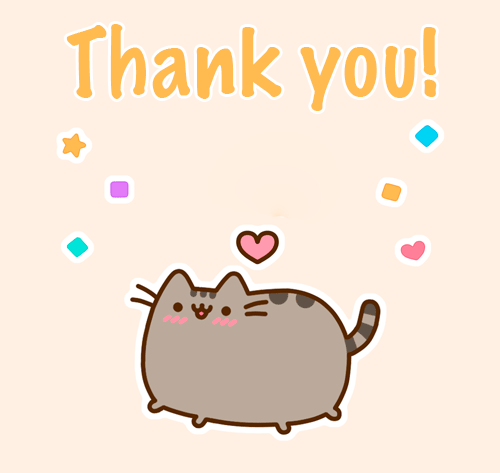

Any comments and suggestions to improve my notebook are very welcomed, and also feel free to talk to me <3